In [1]:
!pip install albumentations
!pip install opencv-python
!pip install keras==2.3.1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.layers import (BatchNormalization, Conv2D, ZeroPadding2D, MaxPooling2D, 
GlobalAveragePooling2D, Dense, Input, Add, Activation, concatenate, UpSampling2D, LeakyReLU, MaxPool2D, Conv2DTranspose)
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import Sequence, plot_model
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sns
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import random 
import cv2
import os
import warnings

warnings.filterwarnings('ignore')

seed = 42


os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_path = '/content/gdrive/My Drive/rosneft/images'
test_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_test_images/img_for_users'
mask_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_train(masks).csv'
weight_path = '/content/gdrive/My Drive/rosneft/resnet34_imagenet_1000.h5'
test_frame_path = '/content/gdrive/My Drive/rosneft/seismic_challenge_sub_baseline_fin.csv'

In [0]:

def jaccard_coef(y_true, y_pred, smoothing = 1.):
    intersection = tf.reduce_sum(y_true * y_pred, axis = (1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis = (1, 2))
    jaccard = (intersection + smoothing) / (union - intersection + smoothing)
    return tf.reduce_mean(jaccard)
    
def jaccard(y_true, y_pred):
    return 1. - jaccard_koef(y_true, y_pred)

def jaccard_loss(y_true, y_pred):
    return 0.75 * jaccard(y_true, y_pred) + 0.25 * binary_crossentropy(y_true, y_pred)

def dice_coef(y_true, y_pred, smoothing = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return ((2. * intersection + smoothing) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smoothing))

def dice(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def dice_loss(y_true, y_pred):
    return 0.75 * dice(y_true, y_pred) + 0.25 * binary_crossentropy(y_true, y_pred)

In [0]:
class UNET:
    def __init__(self, input_shape, num_classes, upsampling = False):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.upsampling = upsampling

    def build(self):
        inp = Input(shape = self.input_shape, name = 'input')
        x = self.block(inp, 64, 3, 'same', 'decode_1')
        x1 = MaxPool2D(name = 'MP_1')(x)
        x = self.block(x1, 128, 3, 'same', 'decode_2')
        x2 = MaxPool2D(name = 'MP_2')(x)
        x = self.block(x2, 192, 3, 'same', 'decode_3')
        x3 = MaxPool2D(name = 'MP_3')(x)
        x = self.block(x3, 256, 3, 'same', 'decode_4')
        x4 = MaxPool2D(name = 'MP_4')(x)
        x = self.block(x4, 256, 3, 'same', 'middle')
        x = concatenate([x, x4], axis = -1)
        x = self.block(x, 256, 3, 'same', 'encode_1')
        x = self.up_vs_transpose(x, filters = 256, kernel_size = (2, 2), padding = 'same', name = '1')
        x = concatenate([x, x3], axis = -1)
        x = self.block(x, 192, 3, 'same', 'encode_2')
        x = self.up_vs_transpose(x, filters = 192, kernel_size = (2, 2), padding = 'same', name = '2')
        x = concatenate([x, x2], axis = -1)
        x = self.block(x, 128, 3, 'same', 'encode_3')
        x = self.up_vs_transpose(x, filters = 128, kernel_size = (2, 2), padding = 'same', name = '3')
        x = concatenate([x, x1], axis = -1)
        x = self.block(x, 64, 3, 'same', 'encode_4')
        x = self.up_vs_transpose(x, filters = 64, kernel_size = (2, 2), padding = 'same', name = '4')
        output = Conv2D(filters = self.num_classes, kernel_size = 1, activation = 'sigmoid', name = 'output')(x)
        model = Model(inp, output)
        return model

    def up_vs_transpose(self, x, filters, kernel_size, padding, name):
        if self.upsampling: 
            x = UpSampling2D(name = 'UpS_{}'.fromat(name))
        else:
            x = Conv2DTranspose(filters, kernel_size, strides = (2, 2), name = 'traspose_{}'.format(name), padding = padding)(x)
        return x
           

    def encode_block(self, x, filters, kernel_size, padding, name):
        x = Conv2D(filters = filters, kernel_size = kernel_size, padding = padding, name = 'Conv2D_{}'.format(name))(x)
        x = BatchNormalization(name = 'BN_{}'.format(name))(x)
        x = LeakyReLU(name = 'LeakyReLu_{}'.format(name))(x)
        return x


    def block(self, x, filters, kernel_size, padding, name):
        x = self.encode_block(x = x, filters = filters, kernel_size = kernel_size, padding = padding, name = '{}-1'.format(name))
        x = self.encode_block(x = x, filters = filters, kernel_size = kernel_size, padding = padding, name = '{}-2'.format(name))
        x = self.encode_block(x = x, filters = filters, kernel_size = kernel_size, padding = padding, name = '{}-3'.format(name))
        return x

In [0]:
model = UNET(input_shape = (None, None, 3), num_classes = 8).build()

In [0]:
def rle2mask(mask_rle, shape):
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype = int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


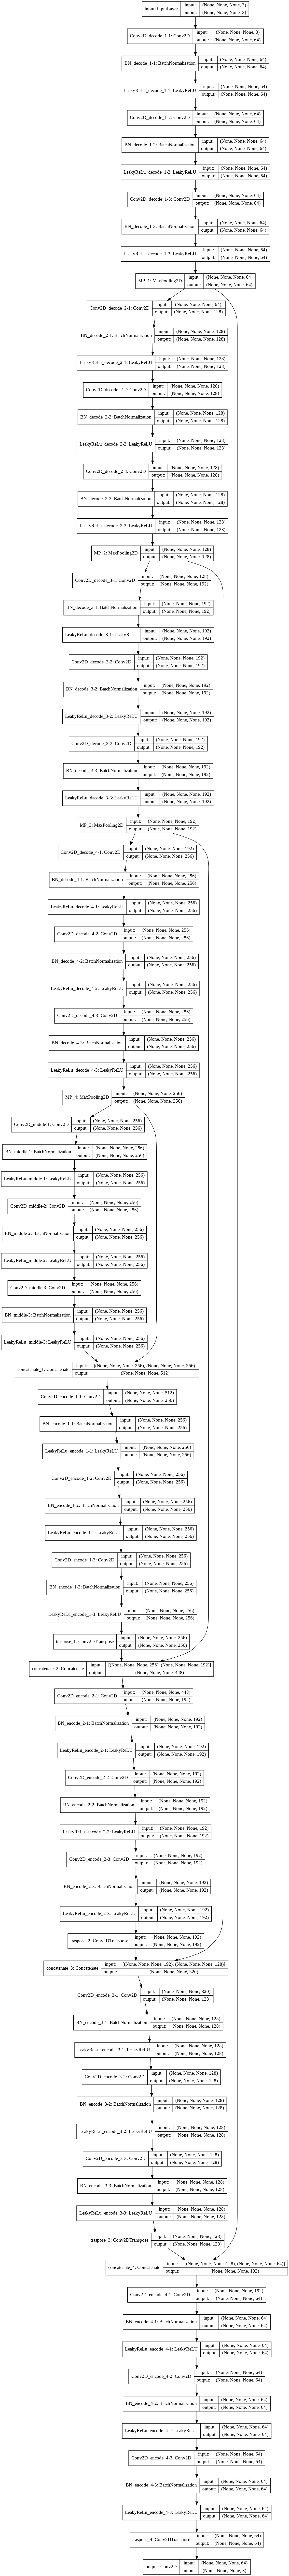

In [9]:
plot_model(model, show_shapes = True)

In [0]:
mask = pd.read_csv(mask_path)

In [11]:
mask.head(5)

,ImageId,ClassId,EncodedPixels
0,inline_3465.png,0,95 25 479 24 863 24 1246 25 1630 25 2014 25 23...
1,inline_3465.png,1,120 9 503 10 887 10 1271 10 1655 9 2039 9 2423...
2,inline_3465.png,2,129 52 513 52 897 52 1281 51 1664 52 2048 52 2...
3,inline_3465.png,3,181 33 565 32 949 32 1332 33 1716 33 2100 32 2...
4,inline_3465.png,4,214 19 597 20 981 20 1365 20 1749 19 2132 20 2...


In [12]:
inlines = []
xlines = []
for img_name in os.listdir(train_path):
    img = cv2.imread(os.path.join(train_path, img_name), cv2.IMREAD_GRAYSCALE)
    if 'inline' in img_name:
        inlines.append(img.shape)
    else:
        xlines.append(img.shape)
        
print('количество инлайнов: ', len(inlines))
print('размеры инлайнов: ', np.unique(inlines, axis = 0))
print('количество икслайнов: ', len(xlines))
print('размеры икслайнов: ', np.unique(xlines, axis = 0))
print('классы: ', mask.ClassId.unique())


del inlines, xlines, img

количество инлайнов:  512
размеры инлайнов:  [[384 384]]
количество икслайнов:  384
размеры икслайнов:  [[384 512]]
классы:  [0 1 2 3 4 5 6]


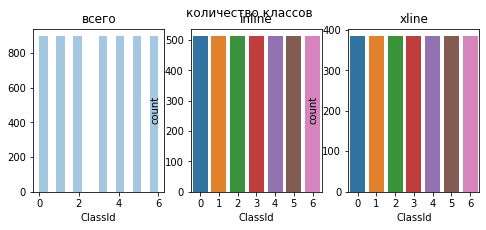

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8, 3))
sns.distplot(mask.ClassId, kde = False, ax = ax1)
sns.countplot(mask[mask.ImageId.apply(lambda s: 1 if 'inline' in s else 0).astype(bool)].ClassId, ax = ax2)
sns.countplot(mask[mask.ImageId.apply(lambda s: 1 if 'xline' in s else 0).astype(bool)].ClassId, ax = ax3)
ax1.set_title('всего')
ax2.set_title('inline')
ax3.set_title('xline')
plt.suptitle('количество классов');

In [14]:
valid_idx = np.random.choice(mask.ImageId.unique(), size = int(0.25 * len(mask.ImageId.unique())), replace = False)
valid_masks = mask[mask.ImageId.isin(valid_idx)]
train = mask[~mask.ImageId.isin(valid_idx)]
test_idx = np.random.choice(train.ImageId.unique(), size = int(0.25 * len(train.ImageId.unique())), replace = False)
test_masks = train[train.ImageId.isin(test_idx)]
train_masks = train[~train.ImageId.isin(test_idx)]
print('size of image set: {}  \n size of train set: {} \n size of valid set: {} \n size of test set: {}'.format(
    len(mask.ImageId.unique()), len(train_masks.ImageId.unique()), len(valid_masks.ImageId.unique()), len(test_masks.ImageId.unique())))

del mask, valid_idx, train, test_idx

size of image set: 896  
 size of train set: 504 
 size of valid set: 224 
 size of test set: 168


In [0]:
def read_img_mask(name_img, train_path, train, one_chanell = False):
    if one_chanell:
        img = np.expand_dims(cv2.imread(os.path.join(train_path, name_img), cv2.IMREAD_GRAYSCALE), axis = 2)
    else:
        img = cv2.imread(os.path.join(train_path, name_img))
    masks = [rle2mask(rle, shape = (img.shape[1], img.shape[0])) 
                for i, rle in enumerate(train[train['ImageId'] == name_img]['EncodedPixels'])]
    mask = np.stack(masks, axis = -1).astype('float')
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis = -1, keepdims = True)
        mask = np.concatenate((mask, background), axis = -1)
    return img, mask

class DataSet:
    def __init__(self, train_path, train, augmentation = None):
        self.train_path = train_path
        self.train = train
        self.augmentation = augmentation
        self.lines = train.ImageId.unique()
    def __getitem__(self, idx):
        name_img = self.lines[idx]
        img, mask = read_img_mask(name_img, self.train_path, self.train)
        if self.augmentation:
            aug = self.augmentation(image = img, mask = mask)
            image, mask = aug['image'], aug['mask']
        return image, mask
    def __len__(self):
        return len(self.lines)
    
class DataLoader(Sequence):    
    def __init__(self, dataset, batch_size = 1, shuffle = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [0]:
def train_augmentation():
    train_transform = [
        A.Resize(384, 384),
        A.HorizontalFlip(p = 0.5),
        A.Rotate(limit = 20, p = 0.5),
        A.ElasticTransform(p = 0.5),
        A.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)),
        ]
    return A.Compose(train_transform)


def val_augmentation():
    test_transform = [
    A.Resize(384, 384),                      
    A.Normalize(
        mean = (0.485, 0.456, 0.406),
        std = (0.229, 0.224, 0.225)),
        ]
    return A.Compose(test_transform)

название изображения: xline_2400.png
размер исходного изображения: (384, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 751 ms, sys: 24.1 ms, total: 776 ms
Wall time: 756 ms


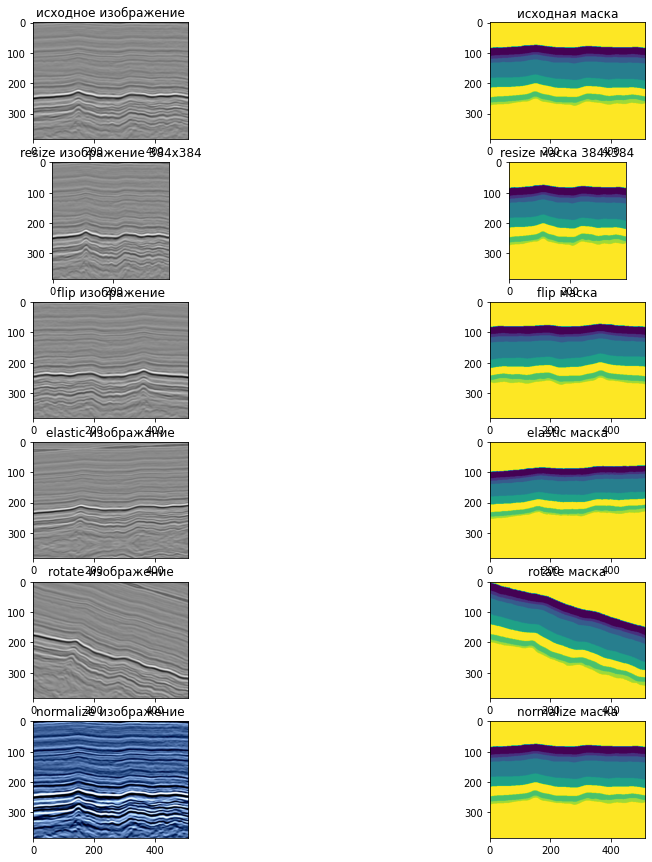

In [17]:
%%time
img_name = train_masks.ImageId.unique()[-1]
print('название изображения:', img_name)
img, mask = read_img_mask(img_name, train_path, train_masks)
print('размер исходного изображения:', img.shape)


def plot(ax, title_img, title_mask, aug):
    img, _mask = aug['image'], aug['mask']
        
    ax[0].imshow(img)
    ax[0].set_title(title_img)

    ax[1].imshow(np.argmax(_mask, axis = -1))
    ax[1].set_title(title_mask)


img_title = ['исходное изображение', 'resize изображение 384x384', 'flip изображение', 
             'elastic изображание', 'rotate изображение', 'normalize изображение']
mask_title = ['исходная маска', 'resize маска 384x384', 'flip маска', 'elastic маска',
              'rotate маска', 'normalize маска']

fig, ax = plt.subplots(len(img_title), 2, figsize = (15, 15))

origin = A.Compose([])(image = img, mask = mask)
resize = A.Compose([A.Resize(384, 384)])(image = img, mask = mask)
flip = A.Compose([A.HorizontalFlip(p = 1)])(image = img, mask = mask)
elastic = A.Compose([A.ElasticTransform(p = 1)])(image = img, mask = mask)
rotate = A.Compose([A.Rotate(limit = 20, p = 1)])(image = img, mask = mask)
normalize = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])(image = img, mask = mask)

aug = [origin, resize, flip, elastic, rotate, normalize]
for a in zip(ax, img_title, mask_title, aug): plot(*a)

In [0]:
BATCH_SIZE = 4
train_dataset = DataSet(train_path, train_masks, augmentation = train_augmentation())
valid_dataset = DataSet(train_path, valid_masks, augmentation = val_augmentation())

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [20]:
%%time

filepath = '/content/gdrive/My Drive/rosneft/unet-weights-improvement-{epoch:02d}-{val_dice:.2f}.hdf5'        
callbacks = [
    EarlyStopping(patience  = 10, verbose = 1),
    ReduceLROnPlateau(factor = 0.1, patience = 4, min_lr = 0.00001, verbose = 1),
    ModelCheckpoint(filepath, monitor = 'val_dice', verbose = 1, save_best_only = True, mode = 'auto', period = 20)
]

total_loss = dice_loss
optim = Adam(lr = 0.0001)
metrics = [dice]
model.compile(optim, total_loss, metrics)

history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch = len(train_dataloader), 
    epochs = 200, 
    callbacks = callbacks, 
    validation_data = valid_dataloader, 
    validation_steps = len(valid_dataloader),
)

Epoch 1/200
126/126 [==============================] - 137s 1s/step - loss: 0.4340 - dice: 0.4876 - val_loss: 0.6910 - val_dice: 0.7647
Epoch 2/200
126/126 [==============================] - 129s 1s/step - loss: 0.2214 - dice: 0.2635 - val_loss: 0.2904 - val_dice: 0.4393
Epoch 3/200
126/126 [==============================] - 126s 997ms/step - loss: 0.1086 - dice: 0.1307 - val_loss: 0.1139 - val_dice: 0.1255
Epoch 4/200
126/126 [==============================] - 118s 940ms/step - loss: 0.0600 - dice: 0.0723 - val_loss: 0.0628 - val_dice: 0.0688
Epoch 5/200
126/126 [==============================] - 128s 1s/step - loss: 0.0411 - dice: 0.0492 - val_loss: 0.0427 - val_dice: 0.0428
Epoch 6/200
126/126 [==============================] - 118s 937ms/step - loss: 0.0309 - dice: 0.0368 - val_loss: 0.0287 - val_dice: 0.0304
Epoch 7/200
126/126 [==============================] - 131s 1s/step - loss: 0.0247 - dice: 0.0293 - val_loss: 0.0242 - val_dice: 0.0248
Epoch 8/200
126/126 [==================

In [21]:
history.history.keys()

dict_keys(['val_loss', 'val_dice', 'loss', 'dice', 'lr'])

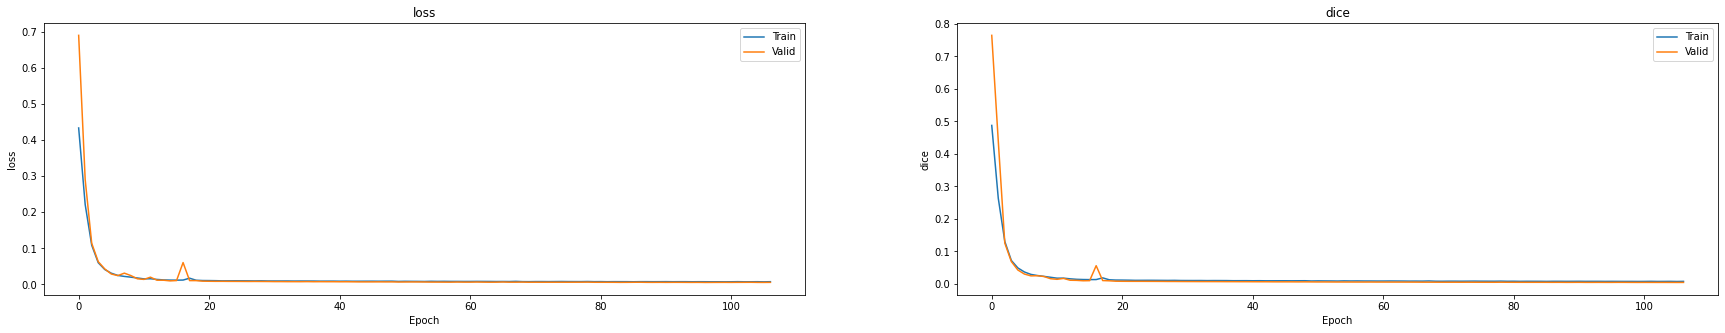

In [22]:
plt.figure(figsize = (30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc = 'upper rigth')

plt.subplot(122)
plt.plot(history.history['dice'])
plt.plot(history.history['val_dice'])
plt.title('dice')
plt.ylabel('dice')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc = 'upper rigth')
plt.show()

In [23]:
%%time
sum_error_jaccard = 0
sum_error_dice = 0
n = len(test_masks.ImageId.unique())
errors = pd.DataFrame(columns = ['image', 'jaccard', 'dice'])
for name_img in test_masks.ImageId.unique():
    img, mask = read_img_mask(name_img, train_path, test_masks)
    
    aug = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])(image = img, mask = mask)
    img, mask = aug['image'], aug['mask']
    
    img = np.expand_dims(img, axis = 0)
    pred = (model.predict(img)).astype('float32')
    mask = mask.astype('float32')
    error_jaccard = K.eval(jaccard_coef(mask, pred[0]))
    error_dice = K.eval(dice_coef(mask, pred[0]))
    errors = errors.append({
        'image': name_img,
        'jaccard': error_jaccard,
        'dice': error_dice
    }, ignore_index = True)
    sum_error_jaccard += error_jaccard
    sum_error_dice += error_dice

print('коэффициент jaccard на тестовой выборке : ', sum_error_jaccard / n)
print('коэффициент dice на тестовой выборке : ', sum_error_dice / n)

коэффициент jaccard на тестовой выборке :  0.9910568839737347
коэффициент dice на тестовой выборке :  0.9953893738843146
CPU times: user 16.7 s, sys: 3.82 s, total: 20.6 s
Wall time: 20.8 s


In [24]:
errors.sort_values(by = 'dice')

,image,jaccard,dice
1,inline_3166.png,0.979881,0.989472
9,inline_3203.png,0.982354,0.990618
92,inline_3671.png,0.982720,0.990853
0,inline_3162.png,0.985923,0.992721
127,xline_2162.png,0.986872,0.993125
...,...,...,...
139,xline_2220.png,0.993355,0.996607
142,xline_2237.png,0.993375,0.996615
141,xline_2227.png,0.993477,0.996670
143,xline_2240.png,0.993553,0.996705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


название изображения:  xline_2221.png
размер изображения:  (384, 512, 3)
размер маски:  (384, 512, 8)
размер предсказания:  (1, 384, 512, 8)
коэффициент jaccard:  0.9842417606794713


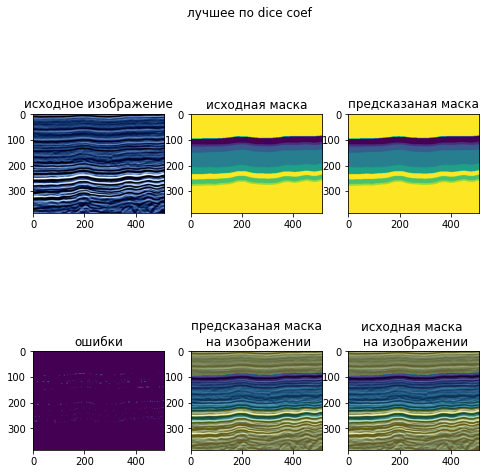

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


название изображения:  inline_3166.png
размер изображения:  (384, 384, 3)
размер маски:  (384, 384, 8)
размер предсказания:  (1, 384, 384, 8)
коэффициент jaccard:  0.9605916181850165


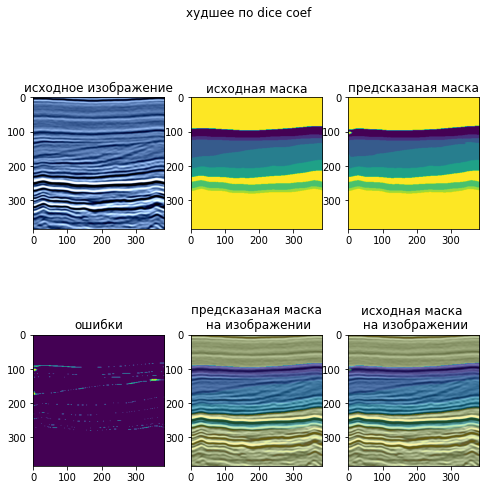

In [25]:
def draw(name_img, title):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (8, 8))
    plt.suptitle(title)
    print('название изображения: ', name_img)
    img, mask = read_img_mask(name_img, train_path, test_masks) 
    aug = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])(image = img, mask = mask)
    img, mask = aug['image'], aug['mask']

    print('размер изображения: ', img.shape)
    print('размер маски: ', mask.shape)

    ax1.imshow(img)
    ax1.set_title('исходное изображение')
    ax2.imshow(np.argmax(mask, axis = -1).astype(np.int32))
    ax2.set_title('исходная маска')

    img = np.expand_dims(img, axis = 0)
    pred = model.predict(img)
    plt.imshow(np.argmax(pred, axis = -1)[0])
    print('размер предсказания: ', pred.shape)


    ax3.imshow(np.argmax(pred, axis = -1)[0])
    ax3.set_title('предсказаная маска')

    error = (np.argmax(mask, axis = -1) != np.argmax(pred, axis = -1))
    ax4.imshow(error[0] > 0)
    ax4.set_title('ошибки')


    ax6.imshow(img[0])
    ax6.imshow(np.argmax(pred, axis = -1)[0], alpha = 0.4)
    ax6.set_title('исходная маска \n на изображении')


    ax5.imshow(img[0])
    ax5.imshow(np.argmax(mask, axis = -1), alpha = 0.4)
    ax5.set_title('предсказаная маска\n на изображении')

    print('коэффициент jaccard: ', K.eval(jaccard_coef(mask, pred)))
    plt.show()


draw('xline_2221.png', 'лучшее по dice coef')
draw('inline_3166.png', 'худшее по dice coef')